In [2]:
import numpy as np
import pandas as pd
import pymc
import matplotlib.pyplot as plt


Text(0, 0.5, 'Number of storms')

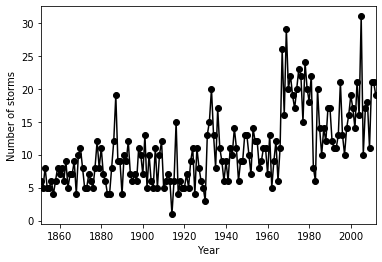

In [26]:
df = pd.read_csv("data/Allstorms.ibtracs_wmo.v03r05.csv", delim_whitespace=False)
cnt = df[df['Basin'] == ' NA'].groupby('Season')['Serial_Num'].nunique()
years = cnt.index
y0, y1 = years[0], years[-1]
arr = cnt.values
plt.plot(years, arr, '-ok')
plt.xlim(y0, y1)
plt.xlabel("Year")
plt.ylabel("Number of storms")

In [27]:
switchpoint = pymc.DiscreteUniform('switchpoint', lower=0, upper=len(arr)) 
early_mean = pymc.Exponential('early_mean', beta=1)
late_mean = pymc.Exponential('late_mean', beta=1)

In [29]:
@pymc.deterministic(plot=False)
def rate(s=switchpoint, e=early_mean, l=late_mean):
    out = np.empty(len(arr))
    out[:s] = e 
    out[s:] = l 
    return out

In [30]:
storms = pymc.Poisson('storms', mu=rate, value=arr, observed=True)

In [31]:
model = pymc.Model([switchpoint, early_mean, late_mean, rate, storms])

In [33]:
mcmc = pymc.MCMC(model)

/home/matsumoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


In [34]:
mcmc.sample(iter=10000, burn=1000, thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 6.7 sec

Text(0, 0.5, 'Late mean')

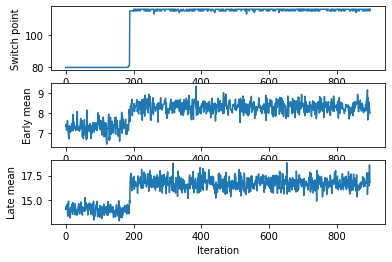

In [36]:
plt.subplot(311)
plt.plot(mcmc.trace('switchpoint')[:]) 
plt.ylabel("Switch point") 
plt.subplot(312) 
plt.plot(mcmc.trace('early_mean')[:]) 
plt.ylabel("Early mean") 
plt.subplot(313) 
plt.plot(mcmc.trace('late_mean')[:]) 
plt.xlabel("Iteration") 
plt.ylabel("Late mean")

Text(0.5, 0, 'Late mean')

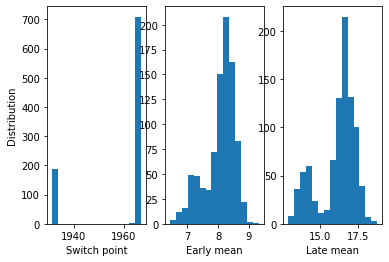

In [37]:
plt.subplot(131) 
plt.hist(mcmc.trace('switchpoint')[:] + y0, 15) 
plt.xlabel("Switch point")
plt.ylabel("Distribution")
plt.subplot(132) 
plt.hist(mcmc.trace('early_mean')[:], 15) 
plt.xlabel("Early mean")
plt.subplot(133) 
plt.hist(mcmc.trace('late_mean')[:], 15) 
plt.xlabel("Late mean")

In [40]:
yp = y0 + mcmc.trace('switchpoint')[:].mean() 
em = mcmc.trace('early_mean')[:].mean()
lm = mcmc.trace('late_mean')[:].mean() 
print((yp, em, lm))

(1959.16, 8.077487398367538, 16.15782119926078)


Text(0, 0.5, 'Number of storms')

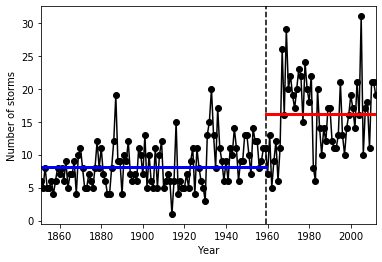

In [41]:
plt.plot(years, arr, '-ok') 
plt.axvline(yp, color='k', ls='--')
plt.plot([y0, yp], [em, em], '-b', lw=3) 
plt.plot([yp, y1], [lm, lm], '-r', lw=3) 
plt.xlim(y0, y1)
plt.xlabel("Year")
plt.ylabel("Number of storms")